# Problem #1

In [1]:
from __future__ import division
import os
import numpy as np
import scipy.io as sio
%matplotlib inline
import matplotlib.pylab as plt

np.random.seed(0)

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.realpath('.'),nargout=0)

In [3]:
def humanColorMatcher(light, primaries):
    """
    A wrapper function for the matlab function humanColorMapper.
    Does the necessary data type transformations to the inputs, 
    calls the matlab function, transforms the output back 
    into numpy, and returns.
    """
    light_mat = matlab.double(light.tolist())
    primaries_mat = matlab.double(primaries.tolist())
    w = eng.humanColorMatcher(light_mat, primaries_mat)
    
    return np.asarray(w)

In [4]:
data = sio.loadmat('./colMatch.mat')
P = data['P']
cones = data['Cones']
phosphors = data['Phosphors']

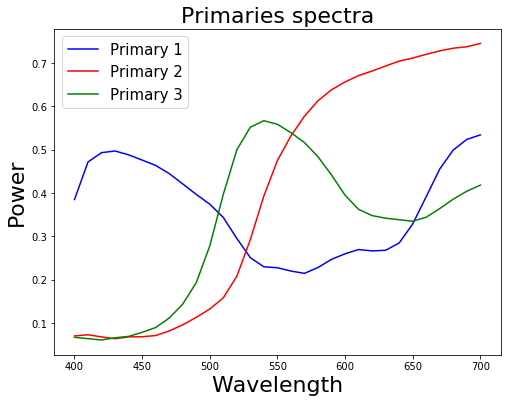

In [38]:
# Let's plot the primaries spectra to get a sense of what they look like
wavelengths = np.linspace(400,700,31)
plt.figure(figsize=(8,6))
# First let's plot the primaries
plt.plot(wavelengths, P[:,0], color='b', label='Primary 1')
plt.plot(wavelengths, P[:,1], color='r', label='Primary 2')
plt.plot(wavelengths, P[:,2], color='g', label='Primary 3')
plt.xlabel('Wavelength', fontsize=22)
plt.ylabel('Power', fontsize=22)
plt.title('Primaries spectra', fontsize=22)
plt.legend(prop={'size': 15})
plt.show()

## (a)

In [6]:
# create arbitrary random test light
light = np.random.uniform(size=(31, 1))

We will denote the "knob settings" returned by humanColorMatcher as a vector $\vec{w}$

In [7]:
# get the response from humanColorMatcher and convert back to numpy
w = humanColorMatcher(light, P)
print w

[[ 1.23878418]
 [ 0.5206864 ]
 [-0.03761998]]


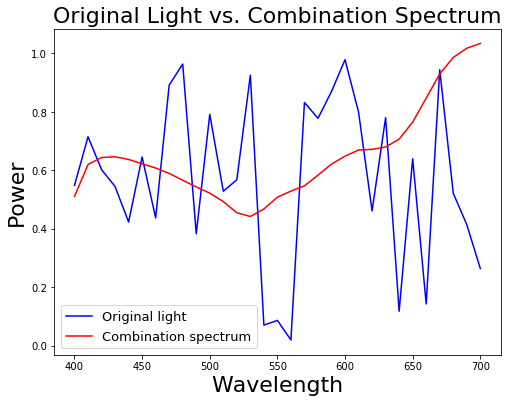

In [37]:
# Let's plot the combination spectrum and compare it to our original light
plt.figure(figsize=(8, 6))
# Now let's plot the combination spectrum
plt.plot(wavelengths, light, color='b', label='Original light')
plt.plot(wavelengths, np.matmul(P, w), color='r', label='Combination spectrum')
plt.xlabel('Wavelength', fontsize=22)
plt.ylabel('Power', fontsize=22)
plt.title('Original Light vs. Combination Spectrum', fontsize=22)
plt.legend(prop={'size': 13})
plt.show()

The two spectra, $P\vec{w}$ and $\vec{l}$, appear to look very different here. It is possible for this to be the case and for the two lights to still look the same to the human, as long as the vectors are similar when we transform them into the space of the human observer (described by a matrix $M$), i.e. $MP\vec{w} \approx M\vec{l}$.

## (b)

For a given primaries matrix P, our human observer can be characterized as a linear system, where the output knob settings $\vec{w}$ are written as a matrix transformation of the input light vector $\vec{l}$:

$\vec{w} = M\vec{l}$.

Here, $M$ is a $3xN$ matrix where $N$ is the number of wavelengths in our spectrum. Note that if we set our input light $\vec{l}$ to be a monochromatic light with non-zero intensity only at spectrum $n$ (i.e. set $\vec{l} = \hat{e}_n$), then we find that

$\vec{w} = M\vec{l} = m_n$,

the $n^{th}$ column vector in $M$. So we can uncover the matrix $M$ by varying our inputs $\vec{l}$ as different unit vectors $\hat{e}_n$, spanning $n=1:N$, and we will uncover the whole matrix $M$.

In [11]:
M = np.zeros((3, 31))
for n in range(31):
    l = np.zeros((31,1))
    l[n,0] = 1
    M[:,n] = humanColorMatcher(l, P).reshape(-1,)

In [22]:
# Verify that out matrix M correctly predicts the output of our function humanColorMatcher
def verify_M(M):
    light = np.random.uniform(size=(31, 1))
    w_func = humanColorMatcher(light, P)
    w_M = np.matmul(M, light)
    # check that these two output vectors are equal
    # within some precision error bound
    assert np.linalg.norm(w_func - w_M) < 1e-5
    print('Test succesfully passed.')
    
# let's run this a couple times, since each time it generates
# a different random input light
verify_M(M)
verify_M(M)
verify_M(M)

Test succesfully passed.
Test succesfully passed.
Test succesfully passed.


So we see that our matrix $M$ correctly predicts the output of the humanColorMatcher function. Now let's find the dimensionality of our nullspace.

In [23]:
def svd(matrix):
    """
    A wrapper for numpy's SVD because numpy returns 
    singular values as an array (weird).
    """
    U, s, Vh = np.linalg.svd(matrix)
    S = np.zeros(matrix.shape, dtype=float)
    S[:len(s), :len(s)] = np.diag(s)
    return U, S, Vh

In [30]:
U, S, Vh = svd(M)
print('U shape: ', U.shape)
print('S shape: ', S.shape)
print('V shape: ', Vh.T.shape)

('U shape: ', (3, 3))
('S shape: ', (3, 31))
('V shape: ', (31, 31))


In [31]:
print S

[[ 1.63144248  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.86474169  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.33562028  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0

So we see that the 3 singular values of $S$ are non-zero. However, we have fewer singular values than we have row vectors in $V^T$ (there are 31). Thus, the information projected onto dimensions 4 through 31 of $V^T$ is thrown away. So the nullspace is the space spanned by the row vectors $[v_4, v_5, ..., v_{31}]$, meaning that our nullspace has a dimensionality of 28 (i.e. 31 - 3). Specifically, it is the space $\mathbb{R}^{28}$.

## (c)

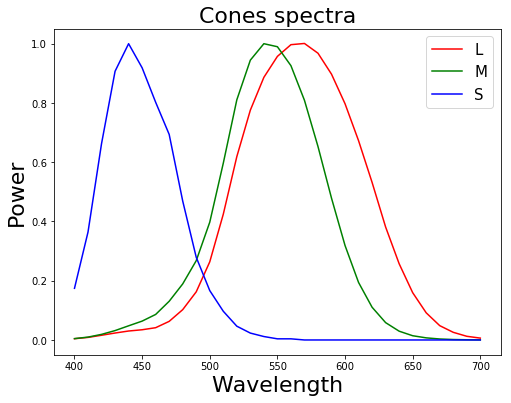

In [36]:
# First let's plot the cones as instructed
wavelengths = np.linspace(400,700,31)
plt.figure(figsize=(8,6))
# First let's plot the primaries
plt.plot(wavelengths, cones[0], color='r', label='L')
plt.plot(wavelengths, cones[1], color='g', label='M')
plt.plot(wavelengths, cones[2], color='b', label='S')
plt.xlabel('Wavelength', fontsize=22)
plt.ylabel('Power', fontsize=22)
plt.title('Cones spectra', fontsize=22)
plt.legend(prop={'size': 15})
plt.show()

In [41]:
# Now let's write a function to verify that the cone absorbtions
# are equal for any pair of lights that are perceptually
# matched
def verify_cones():
    light1 = np.random.uniform(size=(31, 1))
    w = humanColorMatcher(light1, P)
    light2 = np.matmul(P, w)
    # we know that light1 and light2 are perceptually equivalent to a 
    # human observer, by the definition of our function humanColorMatcher.
    # now let's get the cone absorptions for each:
    absorption1 = np.matmul(cones, light1)
    absorption2 = np.matmul(cones, light2)
    # check that they are equal within some precision error
    assert np.linalg.norm(absorption1 - absorption2) < 1e-5
    print('Test succesfully passed.')
    
# Let's run this test a few times (each time a different random
# test light is generated)
verify_cones()
verify_cones()
verify_cones()

Test succesfully passed.
Test succesfully passed.
Test succesfully passed.


So the informal empirical test passes. Now for the formal math.

Assume that we are given two lights $\vec{l_1}$ and $\vec{l_2}$ that are perceptually matched. Then by definition we know this means that $M\vec{l_1} = M\vec{l_2}$ given our human observer matrix $M$. Doing a little bit of algebra, this leads us to $M(\vec{l_1} - \vec{l_2}) = 0$, meaning that $(\vec{l_1} - \vec{l_2})$ lies in the nullspace of the matrix $M$.

Now what we want to show is that, for any two lights $\{\vec{l_1}, \vec{l_2}\}$ as described above, the cone absorptions are equal, meaning that $C\vec{l_1} = C\vec{l_2}$. In other words, we want to show that $C(\vec{l_1} - \vec{l_2}) = 0$. This equality will hold if and only if the vector $(\vec{l_1} - \vec{l_2})$ lies in the nullspace of C.

So ultimately we need to show that if a vector lies in the nullspace of matrix $M$, this necessarily implies that it also lies in the nullspace of $C$. In other words, we need to show that $M$ and $C$ have the same nullspace. Recall from problem (b) that the nullspace for M is $\mathbb{R}^{28}$. We can use similar tactics to find the nullspace for C:

In [44]:
U, S, Vh = svd(cones)
print('U shape: ', U.shape)
print('S shape: ', S.shape)
print('V shape: ', Vh.T.shape)
print(S)

('U shape: ', (3, 3))
('S shape: ', (3, 31))
('V shape: ', (31, 31))
[[ 3.78426349  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          2.16448187  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.7554711   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        

Here we see that we have 3 non-zero singluar values and a $V$ matrix of dimensionality 31x31. Thus, as before with $M$, the information projected onto dimensions 4 through 31 of $V^T$ is thrown away. So the nullspace is the space spanned by the row vectors $[v_4, v_5, ..., v_{31}]$, meaning that our nullspace has a dimensionality of 28 (i.e. 31 - 3). Specifically, it is the space $\mathbb{R}^{28}$.

Therefore $M$ and $C$ have the same nullspace, and we have completed the proof.

## (d)

# Problem #2

In [2]:
# first let's load the data
data = sio.loadmat('./regress1.mat')
x = data['x']
y = data['y']

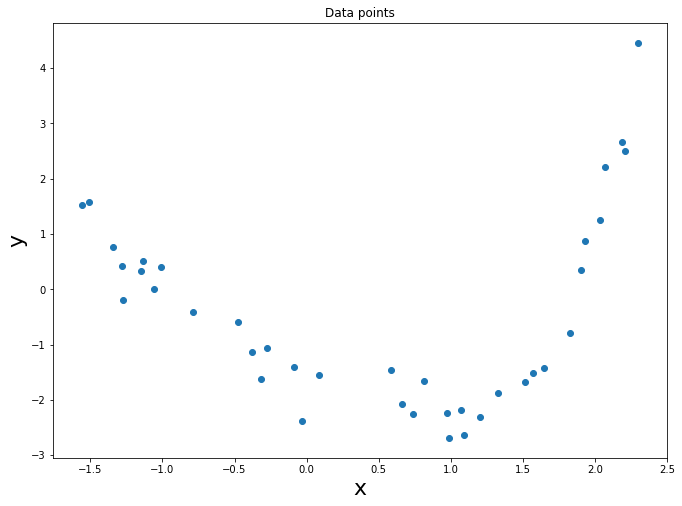

In [3]:
# Let's plot the points to see what they look like
plt.figure(figsize=(11, 8))
plt.title('Data points')
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.scatter(x,y)
plt.show()

For polynomial regression with order $p$, the first step is to formulate a matrix X with colums

$[\vec{x}, \vec{x}^1, \vec{x}^2, ..., \vec{x}^p$].

Then, our objective becomes

$\min_{\vec{\beta}} |\vec{y} - X\vec{\beta}|^2$.

Recall from lecture that, given the SVD decomposition of $X$ into {$U$, $S$, $V^T$}, the optimization objective reduces to

$\min_{\vec{\beta}} |\vec{y}^* - S\vec{\beta}^*|^2$

where $\vec{y}^* = U^T\vec{y}$ and $\vec{\beta}^* = V^T\vec{\beta}$.

The optimal $\beta$ (referred to as $\beta_{opt}$) is described as

$\vec{\beta}_{opt}^* = S^\#\vec{y}^*$

where $S^\#$ is a diagonal matrix with the shape of $S^T$ whose $m^{th}$ diagonal element is $\frac{1}{S_{mm}}$.

In [4]:
def sharp(S):
    """
    A function to convert S into S^# (S_sharp). S_sharp is a 
    diagonal matrix whose mth diagonal element is 1/S_mm. It
    has the shape of S^T.
    """
    S_sharp = np.zeros_like(S)
    n_row, n_col = S.shape
    for r in range(n_row):
        for c in range(n_col):
            if S[r,c] != 0:
                S_sharp[r,c] = 1/S[r,c]
    return S_sharp.T

def polynomial_regression(x, y, order):
    """
    A function to solve the polynomial least-squares regression
    problem for an arbitrary polynomial order.
    """
    # Create the matrix X by concatenating x column vectors of different orders
    cols = [np.power(x, i) for i in range(order+1)]
    X = np.hstack(cols)
    # Obtain SVD decomposition of X
    U, S, Vh = svd(X)
    # Compute B_opt_star
    y_star = np.matmul(U.T, y)
    S_sharp = sharp(S)
    B_opt_star = np.matmul(S_sharp, y_star)
    # Convert B_opt_star into B_opt by reversing the Vh transformation
    B_opt = np.matmul(Vh.T, B_opt_star)
    
    return B_opt

## Order 0

In [5]:
# we will hold B_opt for each order in a dictionary entry
B_opt = {}

In [6]:
B_opt[0] = polynomial_regression(x, y, order=0)

In [7]:
def plot_fit(x, y, B_opt, x_range=None, y_range=None, figsize=None):
    """
    A function to plot the fit for a given polynomial LS solution.
    """
    x_fit = np.linspace(np.min(x), np.max(x), 30).reshape(-1, 1)
    y_fit = 0
    for i, B in enumerate(B_opt):
        y_fit += B*np.power(x_fit, i)
    if figsize is not None:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(11, 8))
    plt.title('Model fit', fontsize=22)
    plt.xlabel('x', fontsize=22)
    plt.ylabel('y', fontsize=22)
    plt.scatter(x, y)
    plt.plot(x_fit, y_fit, color='r')
    if x_range is not None:
        plt.xlim(x_range[0], x_range[1])
    if y_range is not None:
        plt.ylim(y_range[0], y_range[1])
    plt.show()

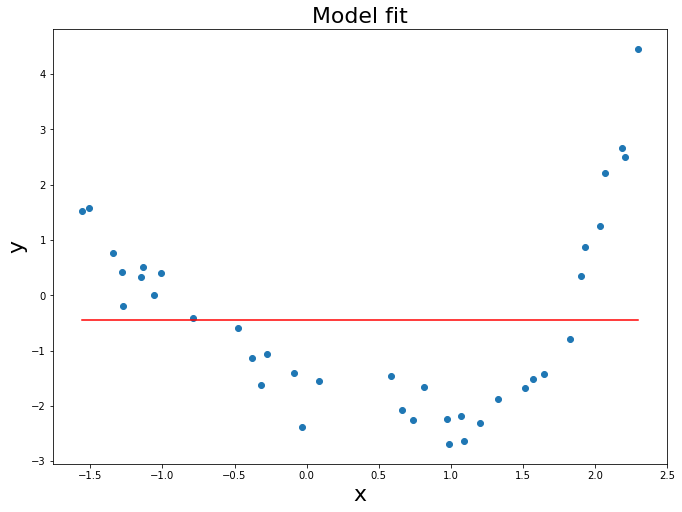

In [8]:
plot_fit(x, y, B_opt[0])

## Order 1

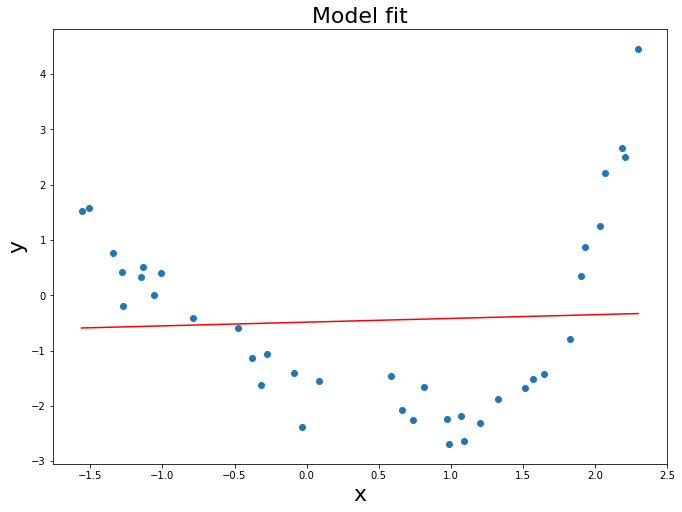

In [9]:
B_opt[1] = polynomial_regression(x, y, order=1)
plot_fit(x, y, B_opt[1])

## Order 2

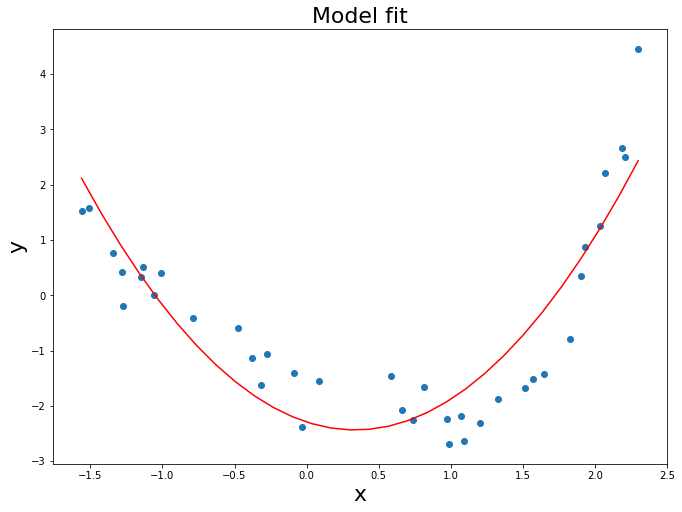

In [11]:
B_opt[2] = polynomial_regression(x, y, order=2)
plot_fit(x, y, B_opt[2])

## Order 3

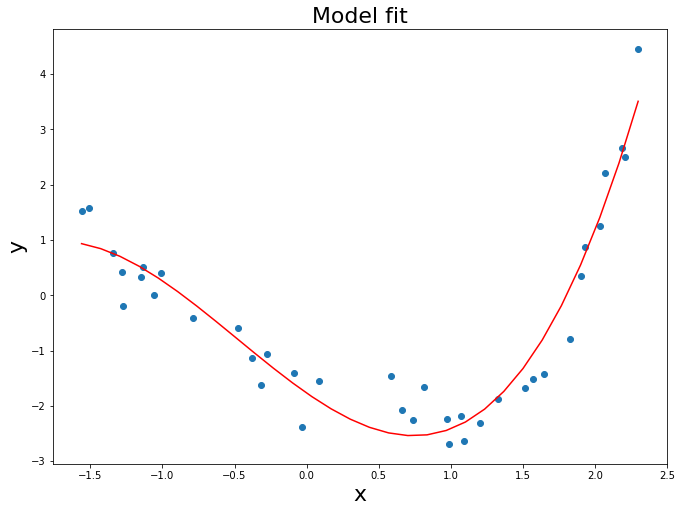

In [12]:
B_opt[3] = polynomial_regression(x, y, order=3)
plot_fit(x, y, B_opt[3])

## Order 4

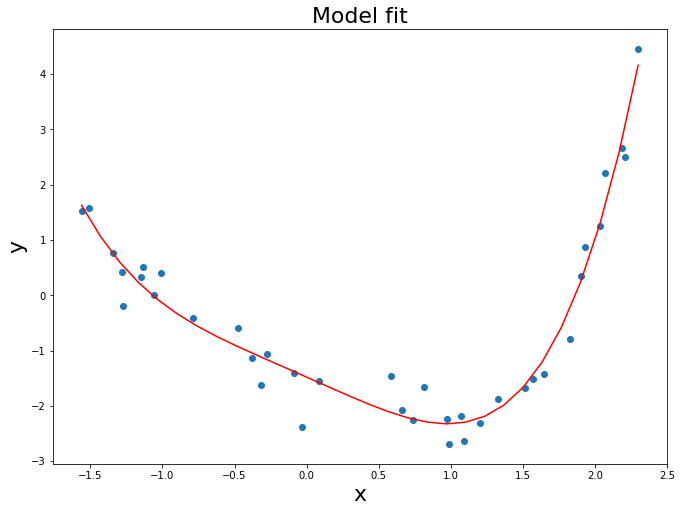

In [13]:
B_opt[4] = polynomial_regression(x, y, order=4)
plot_fit(x, y, B_opt[4])

## Order 5

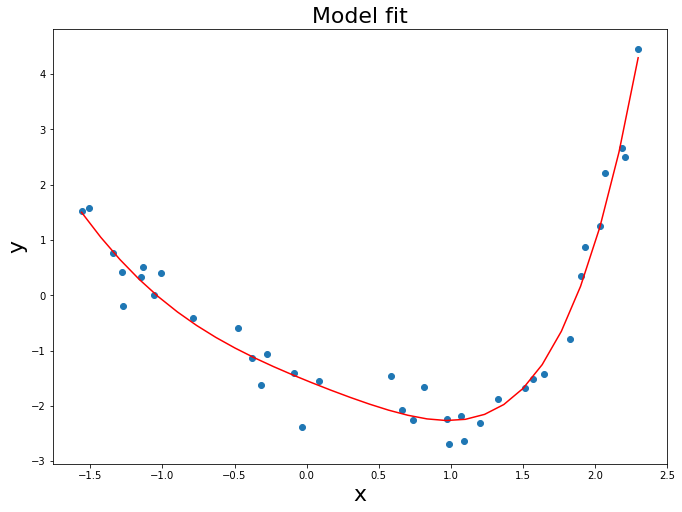

In [14]:
B_opt[5] = polynomial_regression(x, y, order=5)
plot_fit(x, y, B_opt[5])

## Error vs. Order plot

In [15]:
def compute_errors(x, y, B_opt):
    y_p = 0
    for i, B in enumerate(B_opt):
        y_p += B*np.power(x, i)
    
    return np.square(y - y_p)

orders = [elt for elt in range(6)]
errors = [np.sum(compute_errors(x, y, B_opt[i])) for i in orders]

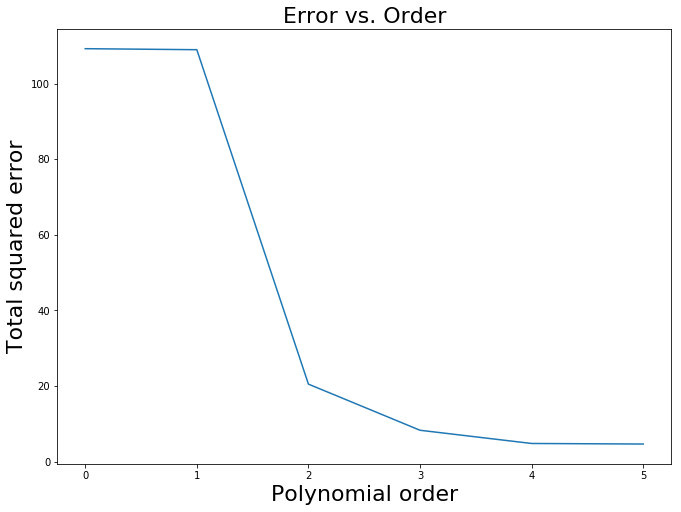

In [16]:
# Let's plot the errors vs order
plt.figure(figsize=(11, 8))
plt.title('Error vs. Order', fontsize=22)
plt.xlabel('Polynomial order', fontsize=22)
plt.ylabel('Total squared error', fontsize=22)
plt.plot(orders, errors)
plt.show()

I think that the fit with order=2 is the best. We know that the squared error for a higher order will always be less than or equal to that of lower order fits. But we don't want to increase the order so much that we overfit our data (i.e. have a model that is too complex). Order=2 looks like a good compromise here because it is the point where the slope of the error begins to flatten out, i.e. where the marginal benefit of adding an aditional order becomes negligible.

# Problem #3

In [17]:
# First let's load the data
data = sio.loadmat('./regress3.mat')
x = data['x']
y = data['y']

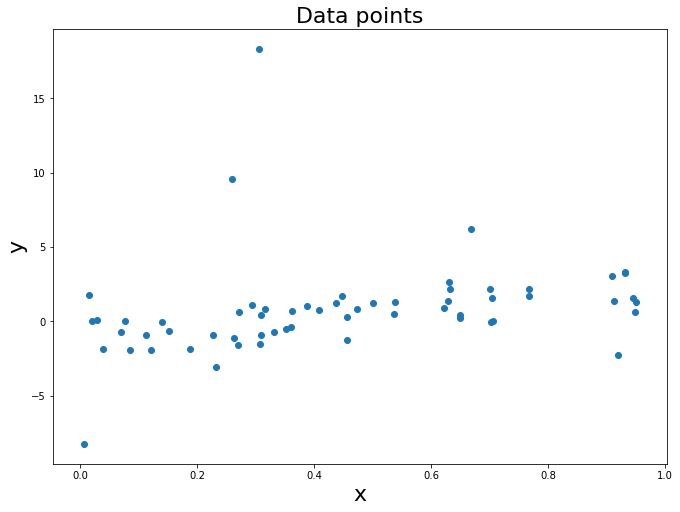

In [18]:
# Let's plot the points to see what they look like
plt.figure(figsize=(11, 8))
plt.title('Data points', fontsize=22)
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.scatter(x,y)
plt.show()

In [19]:
def plot_histogram(x, y, B_opt, bins=None, x_range=None, y_range=None, figsize=None):
    """
    TODO
    """
    errors = compute_errors(x, y, B_opt)
    if figsize is not None:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(11,8))
    plt.title('Error histogram', fontsize=22)
    plt.xlabel('Squared error', fontsize=22)
    plt.ylabel('Frequency', fontsize=22)
    plt.hist(errors, bins=bins)
    if x_range is not None:
        plt.xlim(x_range[0], x_range[1])
    if y_range is not None:
        plt.ylim(y_range[0], y_range[1])
    plt.show()

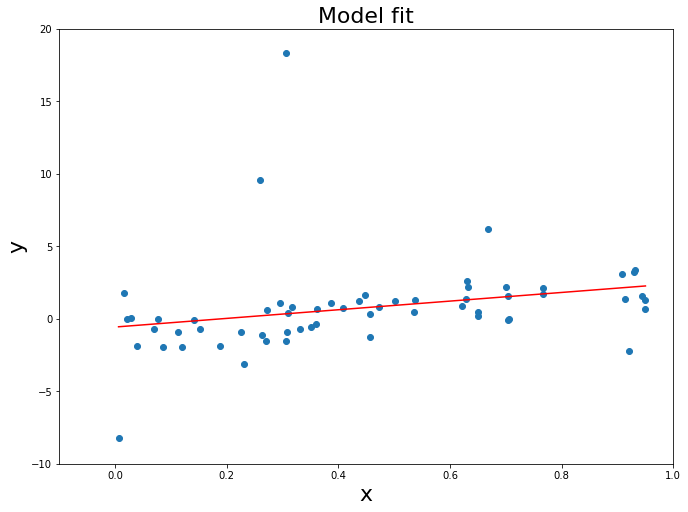

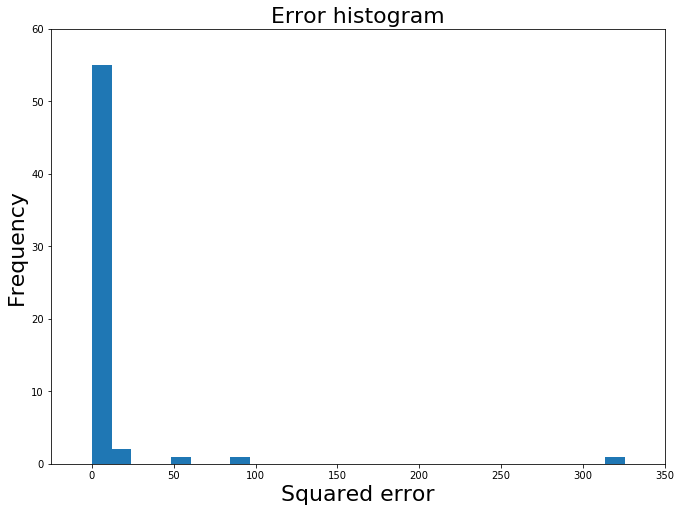

In [20]:
# To solve the standard LS regression problem using a constant 
# and a linear term, we can use our polynomial function from 
# problem #2 with order=1.
B_opt = polynomial_regression(x, y, order=1)
plot_fit(x, y, B_opt, x_range=[-0.1, 1.0], y_range=[-10, 20])
# Now let's plot a histogram of the errors
bins = np.linspace(0, 350, 30)
plot_histogram(x, y, B_opt, bins=bins, x_range=[-25, 350], y_range=[0, 60])

In [21]:
def trimmed_regression(x, y, nb_trim, plot=True):
    """
    A function to take a set of points, {x, y}, and a # of iterations,
    nb_trim, and iteratively fit (LR regression) and remove the worst-fitting
    point nb_trim times. After each removal, the new fit is plotted (w/ remaining
    points only) and the histogram of errors is also plotted.
    """
    error_avgs = np.zeros((nb_trim,))
    # Compute the initial fit
    B_opt = polynomial_regression(x, y, order=1)
    # Loop through nb_trim times, removing the worst point each time
    for i in range(nb_trim):
        # Compute the errors for each point
        errors = compute_errors(x, y, B_opt)
        error_avgs[i] = np.mean(errors)
        ind_max = np.argmax(errors)
        x = np.delete(x, ind_max).reshape(-1,1)
        y = np.delete(y, ind_max).reshape(-1,1)
        B_opt = polynomial_regression(x, y, order=1)
        if plot:
            # Now let's plot the results for this iteration
            print('TRIMMING %i DATA POINTS\n' % (i+1))
            plot_fit(x, y, B_opt, x_range=[-0.1, 1.0], y_range=[-10, 20], figsize=(8, 6))
            # plot error histogram
            bins = np.linspace(0, 350, 30)
            plot_histogram(x, y, B_opt, bins=bins, x_range=[-25, 350], y_range=[0, 60],
                           figsize=(8, 6))
        
    return error_avgs, x, y, B_opt

TRIMMING 1 DATA POINTS



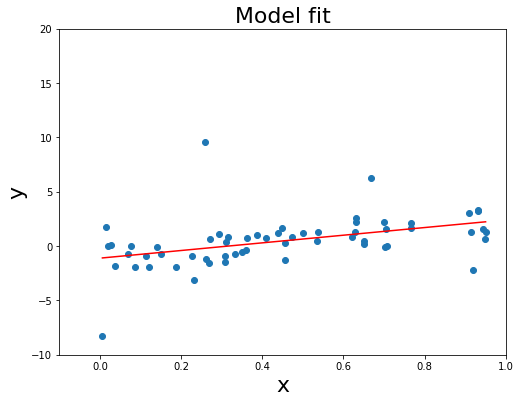

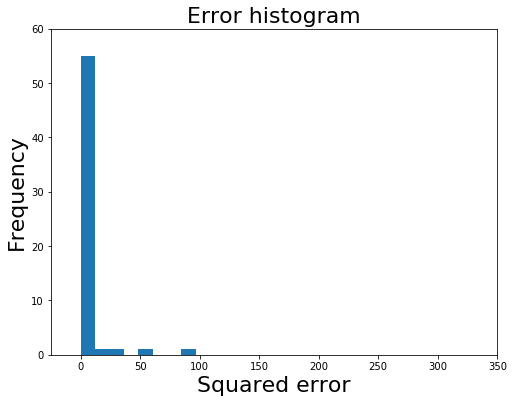

TRIMMING 2 DATA POINTS



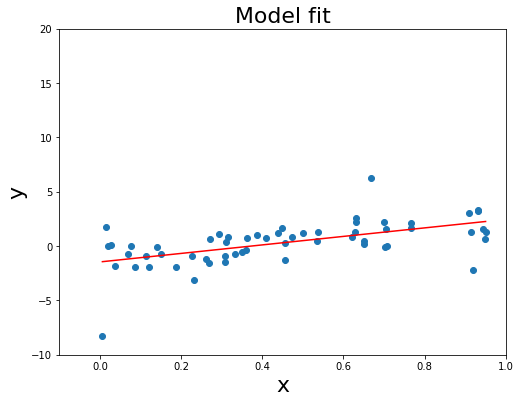

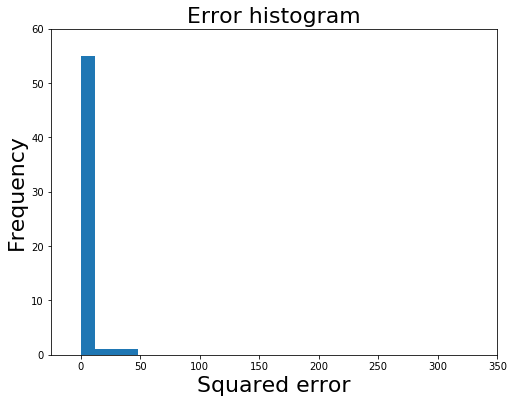

TRIMMING 3 DATA POINTS



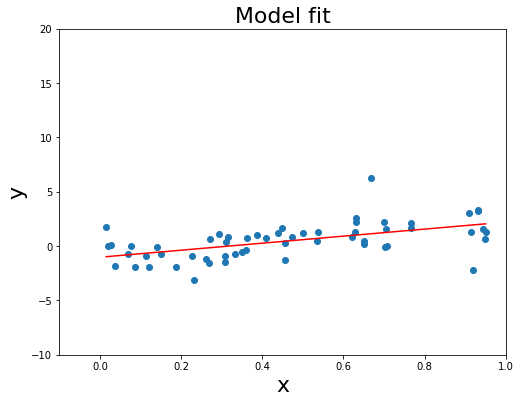

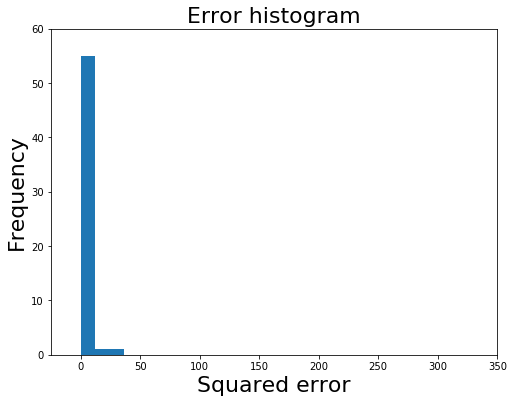

TRIMMING 4 DATA POINTS



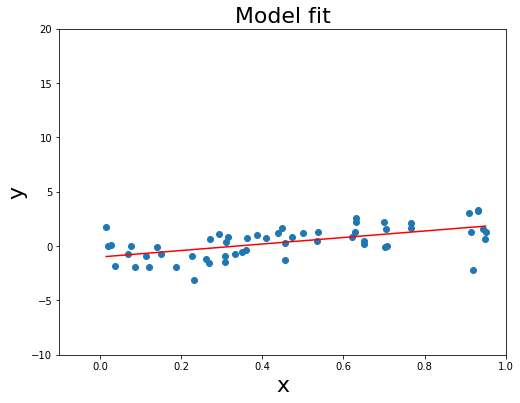

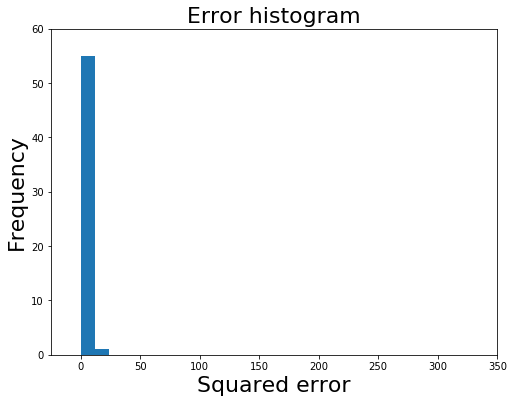

TRIMMING 5 DATA POINTS



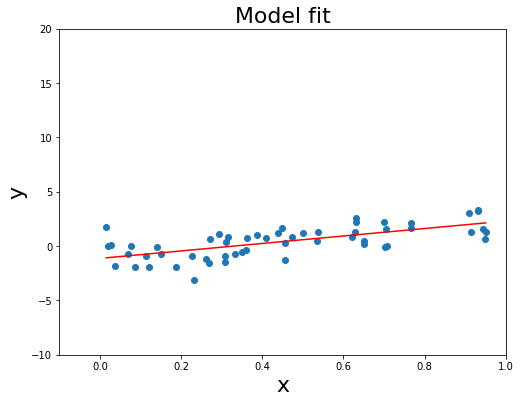

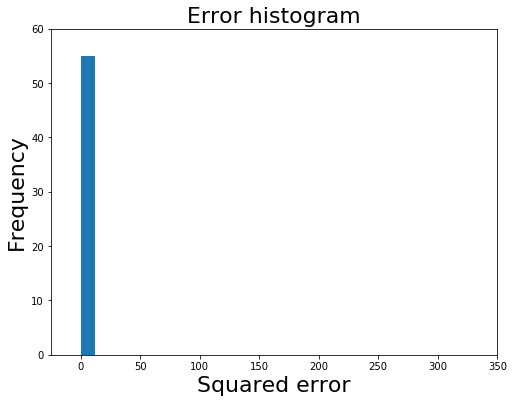

TRIMMING 6 DATA POINTS



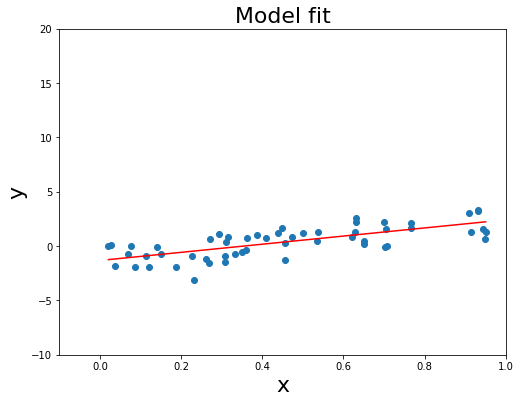

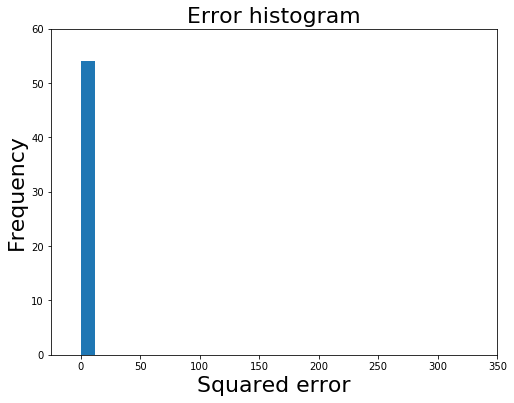

TRIMMING 7 DATA POINTS



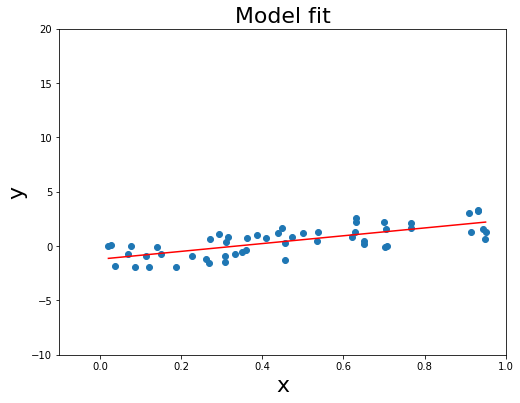

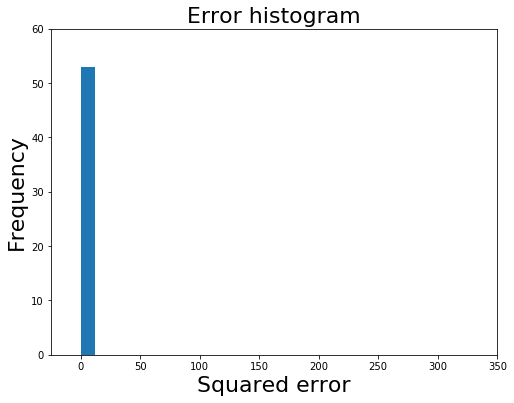

TRIMMING 8 DATA POINTS



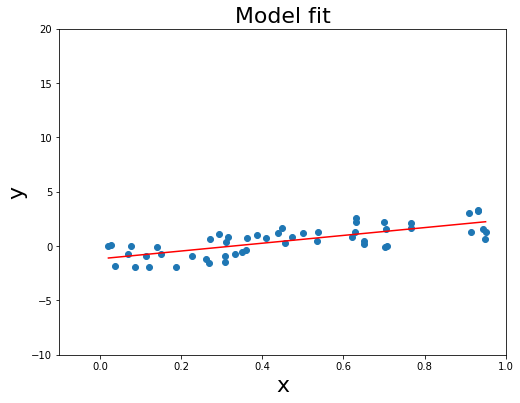

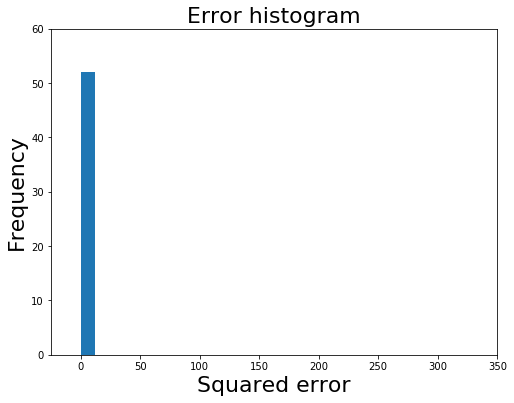

TRIMMING 9 DATA POINTS



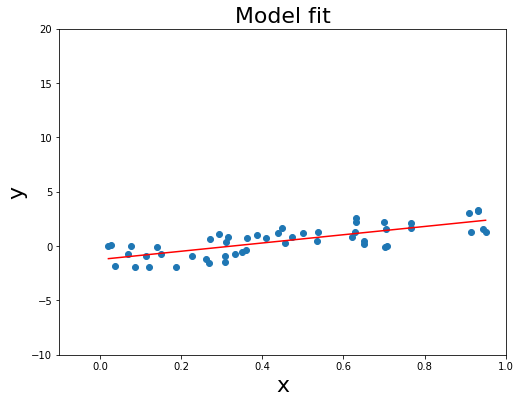

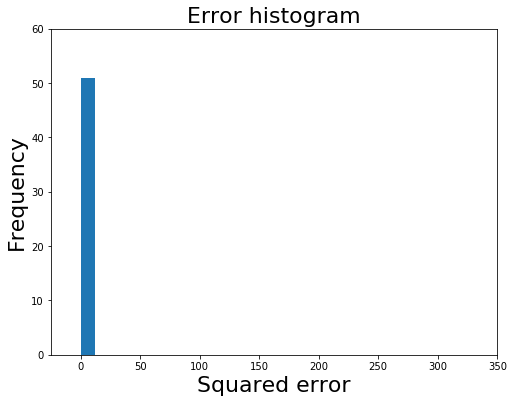

TRIMMING 10 DATA POINTS



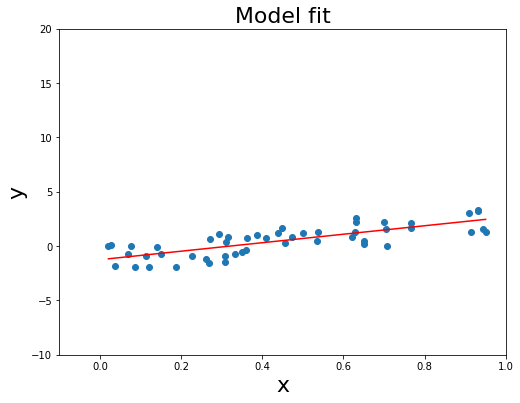

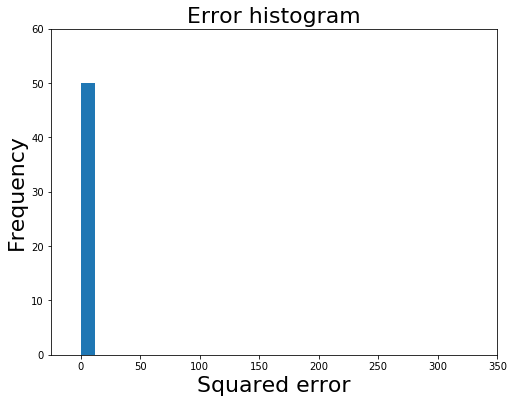

TRIMMING 11 DATA POINTS



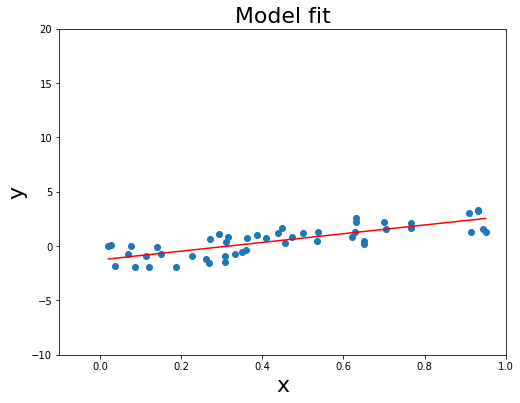

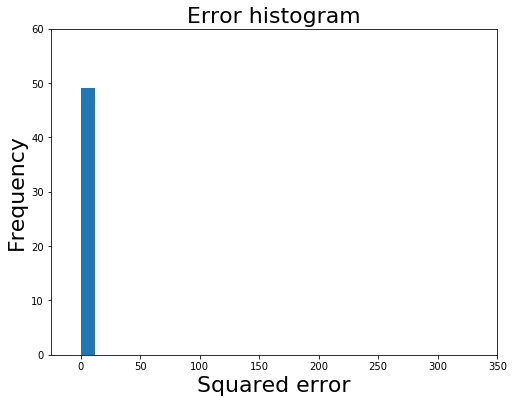

TRIMMING 12 DATA POINTS



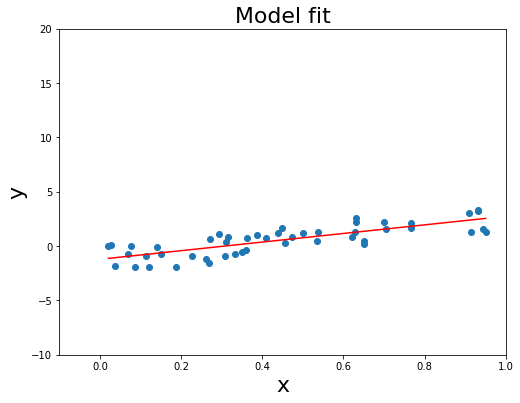

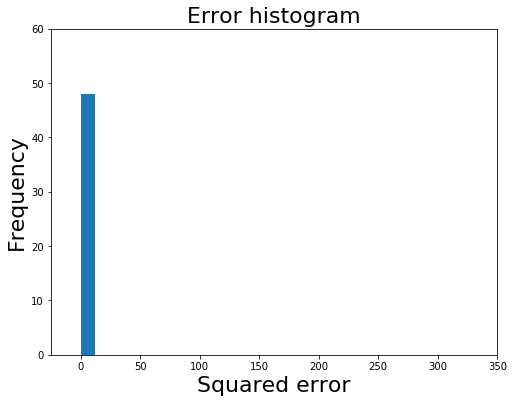

TRIMMING 13 DATA POINTS



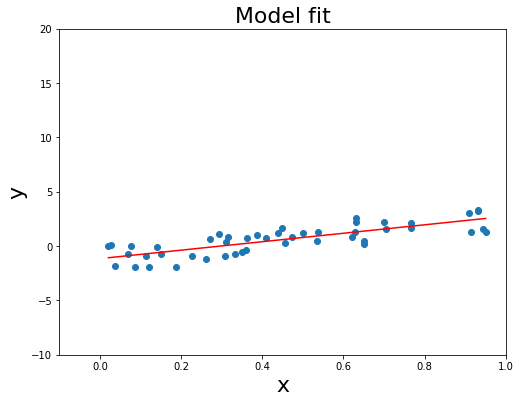

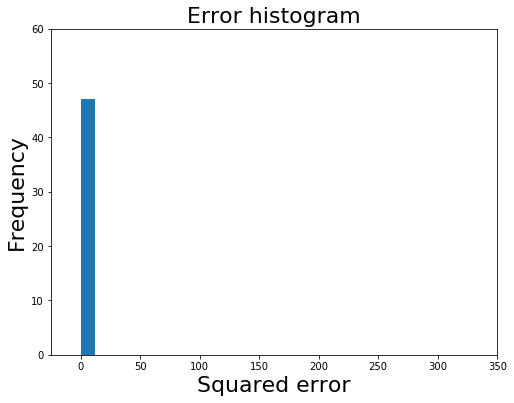

TRIMMING 14 DATA POINTS



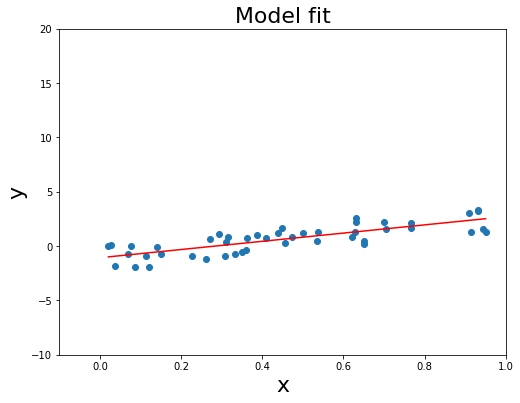

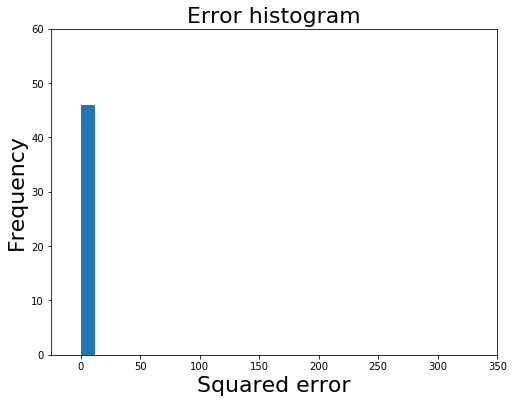

TRIMMING 15 DATA POINTS



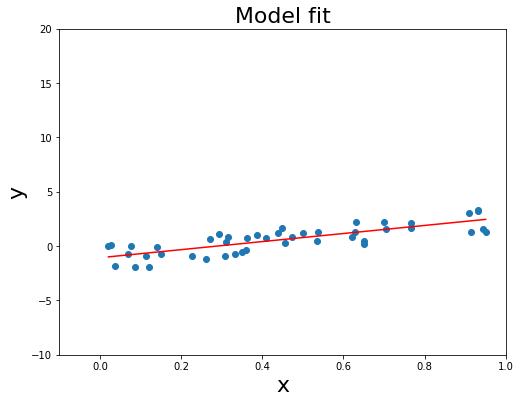

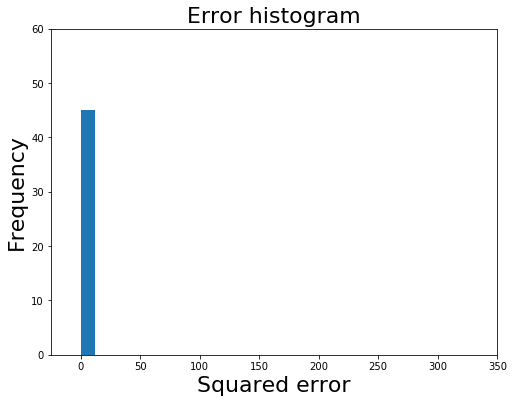

TRIMMING 16 DATA POINTS



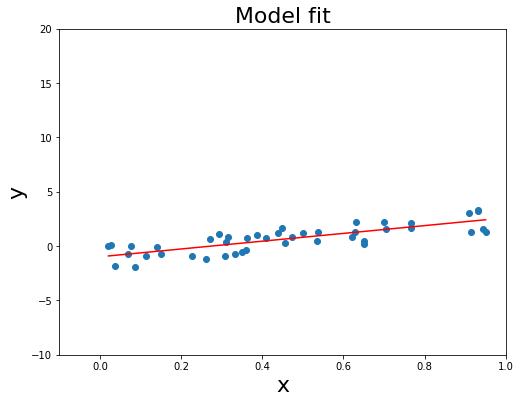

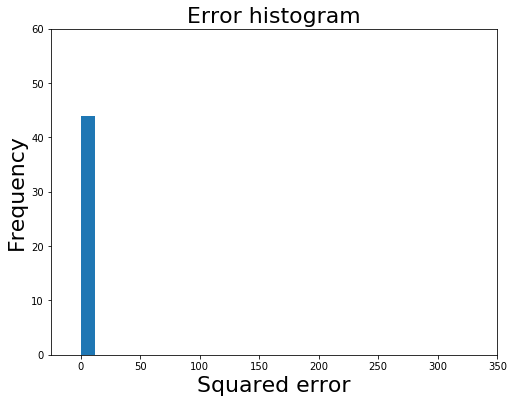

TRIMMING 17 DATA POINTS



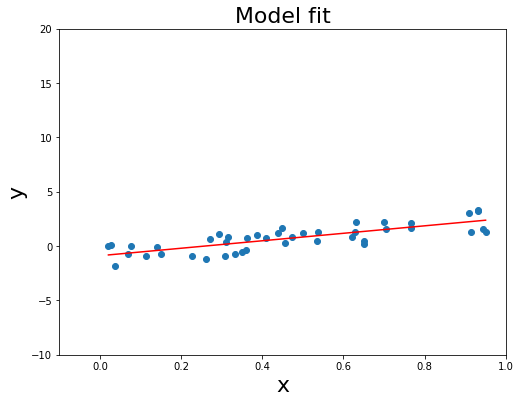

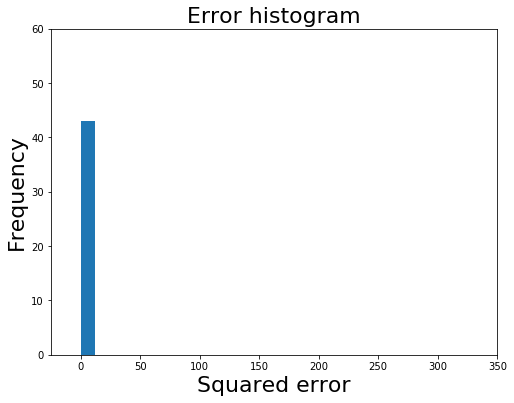

TRIMMING 18 DATA POINTS



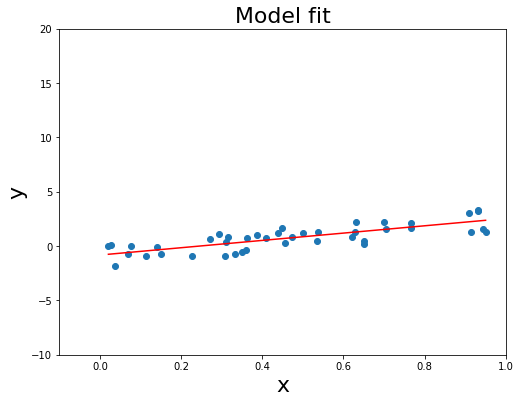

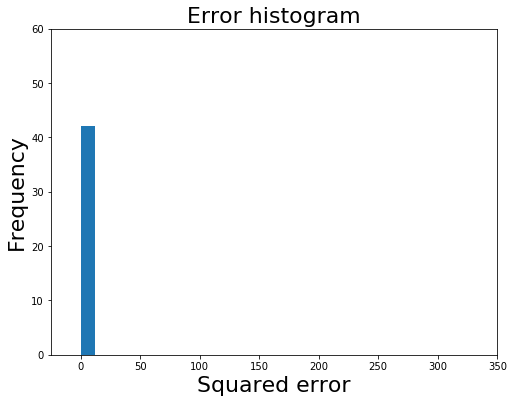

TRIMMING 19 DATA POINTS



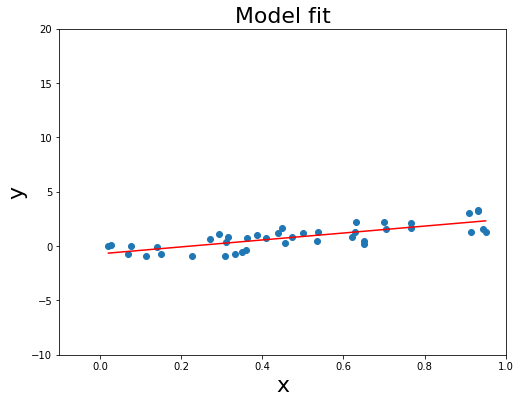

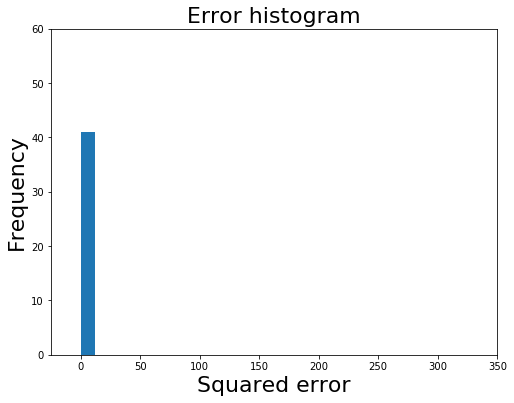

TRIMMING 20 DATA POINTS



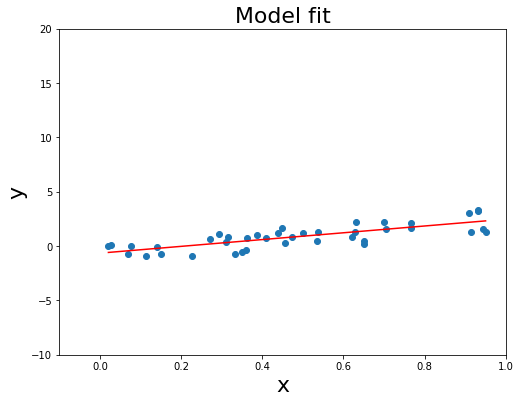

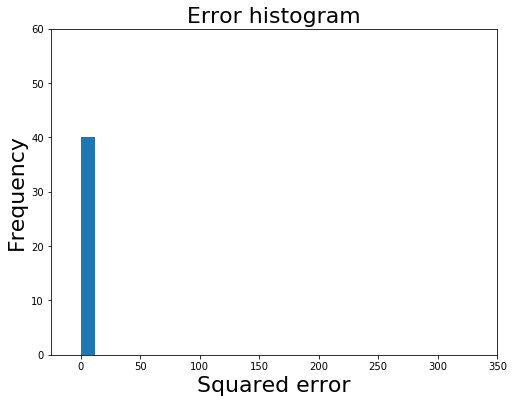

TRIMMING 21 DATA POINTS



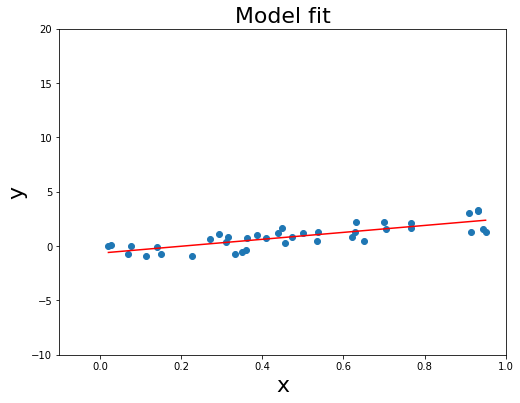

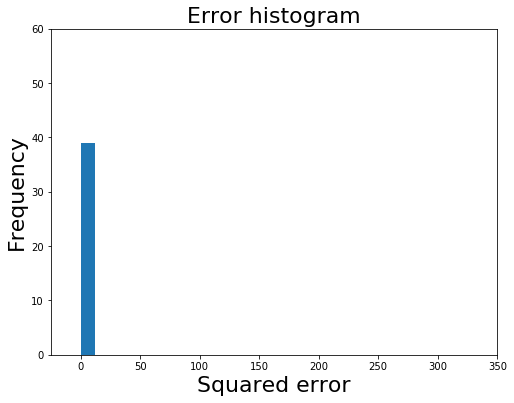

TRIMMING 22 DATA POINTS



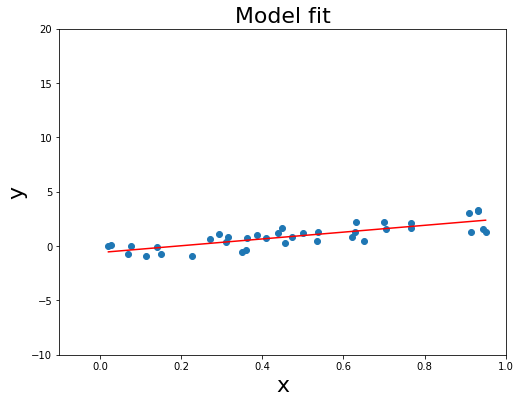

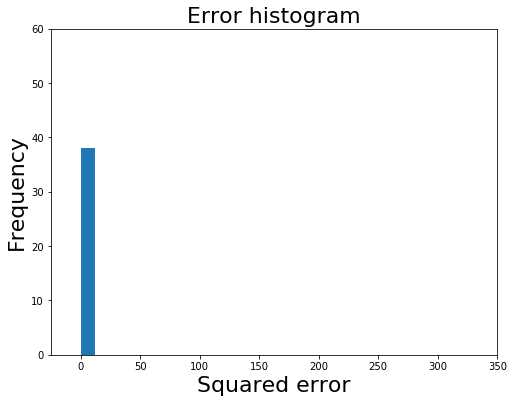

TRIMMING 23 DATA POINTS



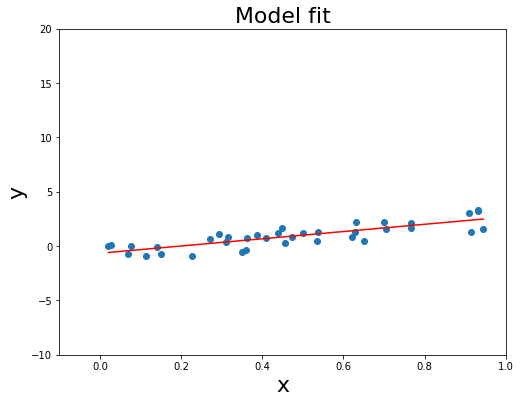

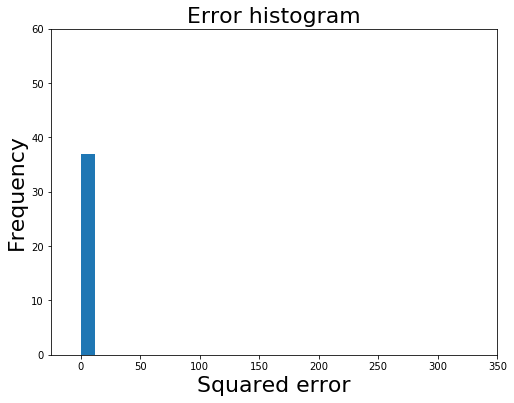

TRIMMING 24 DATA POINTS



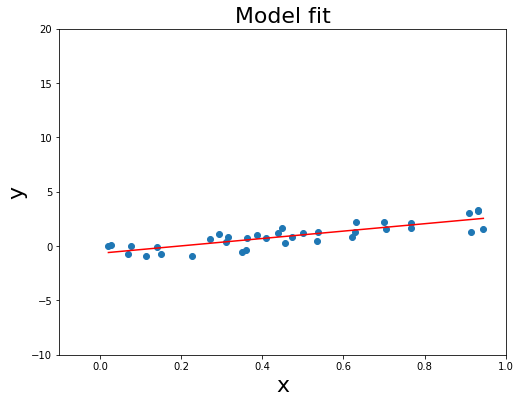

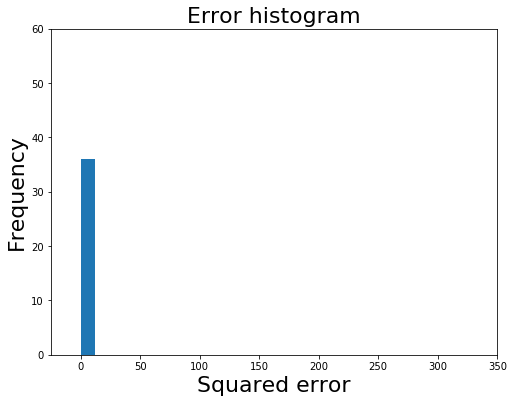

TRIMMING 25 DATA POINTS



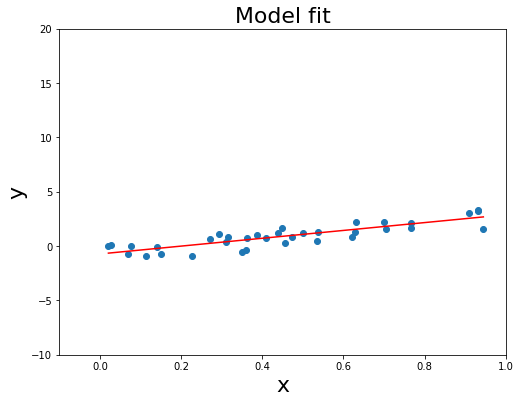

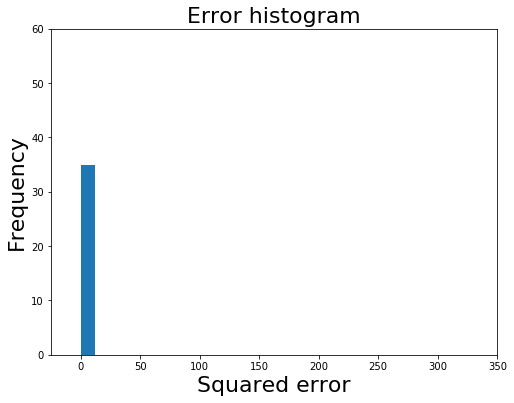

TRIMMING 26 DATA POINTS



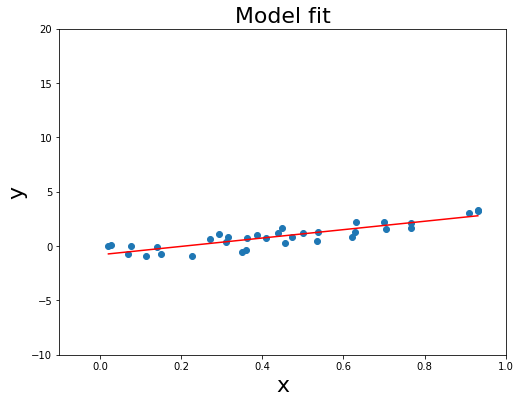

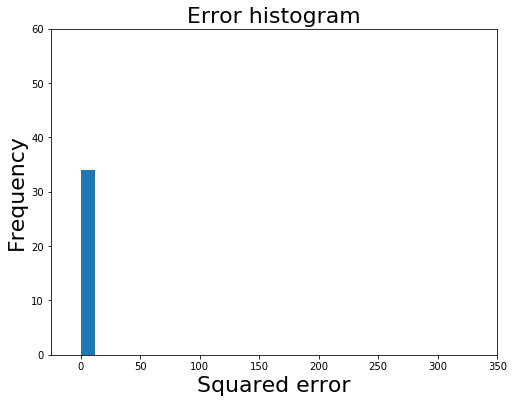

TRIMMING 27 DATA POINTS



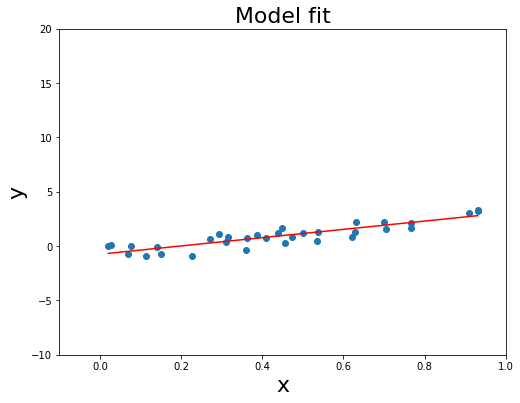

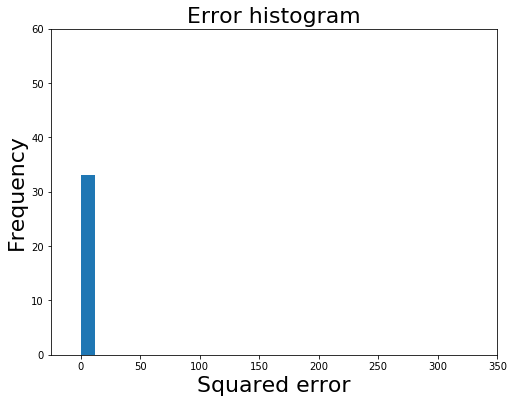

TRIMMING 28 DATA POINTS



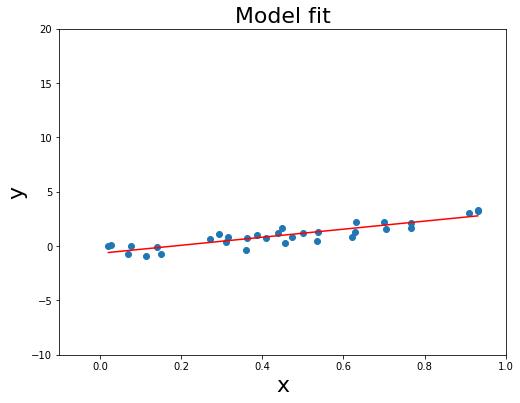

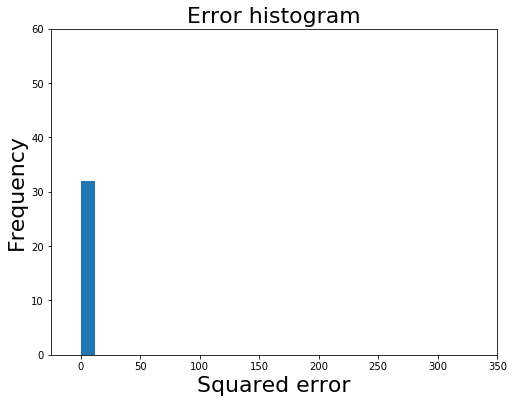

TRIMMING 29 DATA POINTS



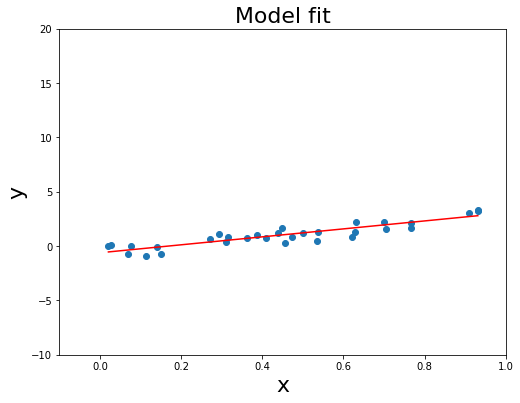

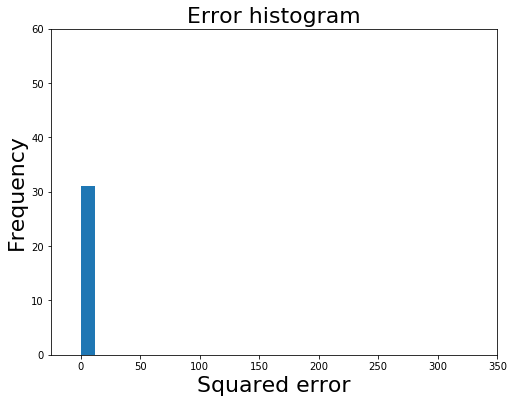

TRIMMING 30 DATA POINTS



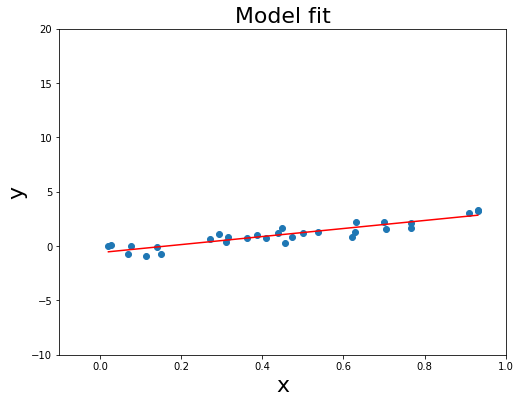

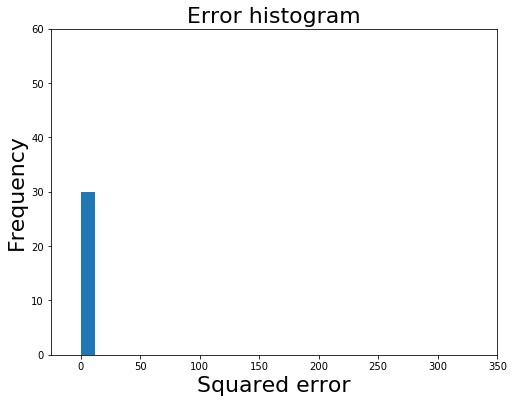

In [22]:
# Looping through the trimming operations. You will need to scroll
# through this window to see the results of each iteration.
error_avgs, _, _, _ = trimmed_regression(x, y, nb_trim=int(len(x)/2))

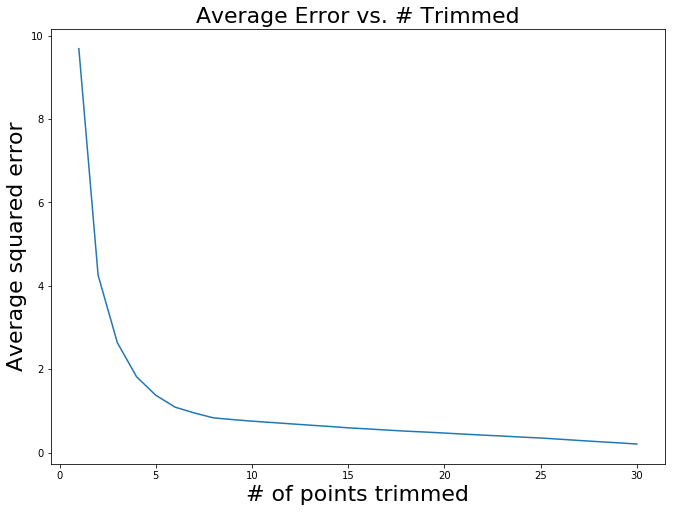

In [23]:
# Let's plot the errors vs nb_trim
plt.figure(figsize=(11, 8))
plt.title('Average Error vs. # Trimmed', fontsize=22)
plt.xlabel('# of points trimmed', fontsize=22)
plt.ylabel('Average squared error', fontsize=22)
plt.plot(range(1,int(len(x)/2)+1), error_avgs)
plt.show()

The best fit to me is the point that defines the "elbow" of the error vs. # trimmed curve, i.e. the point where the marginal benefit of trimming another point becomes negligible. Here, it looks like that occurs at #trimmed = 5. Looking at the histograms for each iteration, this appears to be a good choice as well, because #trimmed = 5 is the first iteration for which all of the data points fall into the lowest bin of the histogram.

In [24]:
# Let's find the fit for nb_trim=5
_, x_p, y_p, B_opt = trimmed_regression(x, y, nb_trim=5, plot=False)

In [25]:
# Now let's figure out which points were trimmed using
# set difference
diff = set(x.reshape(-1,)).difference(x_p.reshape(-1,))
diff = list(diff)
# find the indices of the removed values
ind_diff = [np.where(x == elt)[0][0] for elt in diff]
x_rm = x[ind_diff]
y_rm = y[ind_diff]

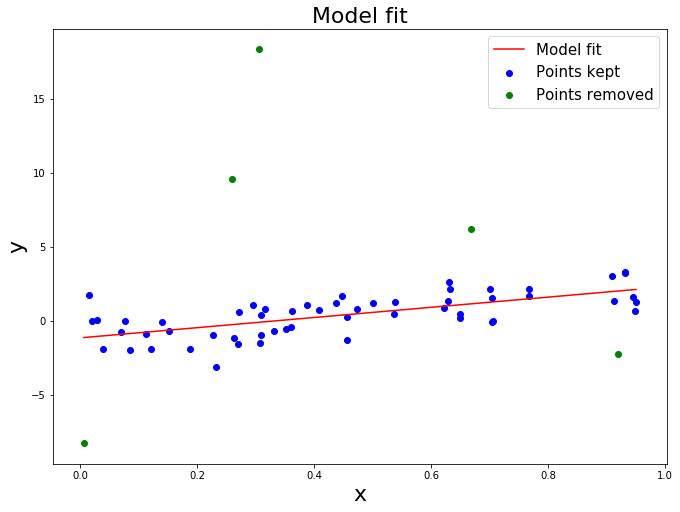

In [26]:
# Let's plot the points and the model fit, using different
# colors for the points we removed vs. the points we kept
x_fit = np.linspace(np.min(x), np.max(x), 30).reshape(-1, 1)
y_fit = 0
for i, B in enumerate(B_opt):
    y_fit += B*np.power(x_fit, i)
plt.figure(figsize=(11, 8))
plt.title('Model fit', fontsize=22)
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.scatter(x_p, y_p, color='b', label='Points kept')
plt.scatter(x_rm, y_rm, color='g', label='Points removed')
plt.plot(x_fit, y_fit, color='r', label='Model fit')
plt.legend(prop={'size': 15})
plt.show()

Yes I think I made a good choice. The points that appear to be the most significant outliers have all been removed.

# Problem #4

In [253]:
data = sio.loadmat('./constrainedLS.mat')
D = data['data']
w = data['w']
print('{w_x: %0.3f, w_y: %0.3f}' % (w[0,0], w[1,0]))

{w_x: 0.540, w_y: 0.240}


## (a)

Our objective can be rewritten in matrix form as follows:

$\min_{\vec{v}} ||D\vec{v}||^2$ subject to $\vec{v}^T\vec{w} = 1$.

Now, let's rewrite this to get a new objective, $\min ||\tilde{v}||^2$, for some vector $\tilde{v}$. Denote $\{U, S, V^T\}$ the SVD decomposition of matrix D. Then our objective can be rewritten as follows:

$||D\vec{v}|| = ||USV^T\vec{v}||^2 = ||SV^T\vec{v}||^2$.

Now, if we denote a new vector $\tilde{v} = SV^T\vec{v}$, then we have the new objective

$\min_{\tilde{v}}||\tilde{v}||^2$ subject to $(VS^\#\tilde{v})^T\vec{w} = 1$

as we desired ($S^\#$ is the pseudoinverse of S, which can be easily computed using our "sharp" function from q2).

## (b)

In [255]:
# We know that v must lie on a line perpendicular to w that has
# a perpendicular distance from the origin of 1/|w|. Let's find
# This line.

# First, let's compute the slope of w (call it alpha)
alpha = w[1,0]/w[0,0]
# Since our target line is perpendicular to w, it will
# have a slope -1/alpha
alpha_p = -1/alpha

# Now, let's get the point that is 1/|w| distance from the
# origin in the direction of vector w
w_hat = w/np.linalg.norm(w)
point = (1/np.linalg.norm(w))*w_hat

print('slope: %0.3f' % alpha_p)
print('point: {x: %0.3f, y: %0.3f}' % (point[0,0], point[1,0]))

slope: -2.250
point: {x: 1.546, y: 0.687}


So since we have the slope $m$ of our line and a point $\{x_0, y_0\}$ that it passes through, we can use the line equation

$(y - y_0) = m*(x - x_0)$

to get our line equation. I've written a function to compute the y-intercept.

In [256]:
def compute_yintercept(slope, point):
    """
    A function to compute a line equation. Takes as input the slope
    of the line and a point that it passes through, and returns the
    y_intercept.
    :param point: An array of shape (2,)
    """
    # (y-y0) = m*(x-x0)
    # (y-y0) = m*x - m*x0
    # y = m*x - m*x0 + y0
    # so the y intercept is
    # y_int = -m*x0 + y0
    return -slope*point[0] + point[1]

In [257]:
compute_yintercept(alpha_p, point.reshape(-1,))

4.166666666666667

So we have a line $y = -2.250x + 4.167$.

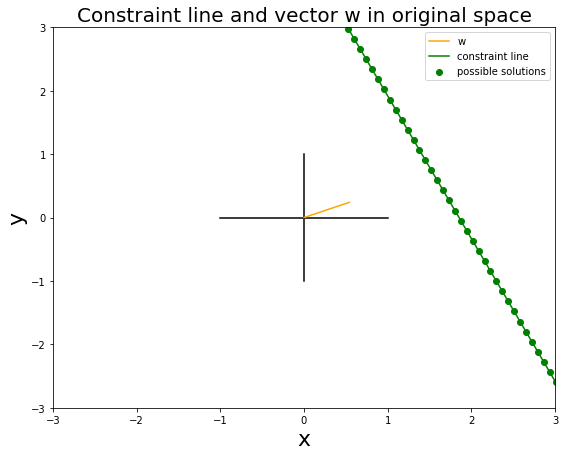

In [258]:
# Let's plot the possible solution points in their 
# original space to see what they look like
plt.figure(figsize=(9, 7))
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.xlim(-3,3)
plt.ylim(-3,3)
# plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# plot the vector w
plt.plot([0, w[0]], [0, w[1]], color='orange', label='w')
# plot the constraint line
x_grid = np.linspace(-3.5, 3.5, 100) # create a grid of y values
y_grid = -2.250*x_grid + 4.167 # here we use our line equation
plt.scatter(x_grid, y_grid, color='green', label='possible solutions')
plt.plot(x_grid, y_grid, color='green', label='constraint line')
plt.legend()
plt.title('Constraint line and vector w in original space', fontsize=20)
plt.show()

In [259]:
# Now, compute SVD of our matrix D and run the transformations:
U, S, Vh = svd(D)
# Now, convert the constraint line into our new space.
# First, let's collate the constraint line points into vector form
c = np.asarray([x_grid, y_grid])
# Now, let's transform them
c_tilde = np.matmul(S, np.matmul(Vh, c))

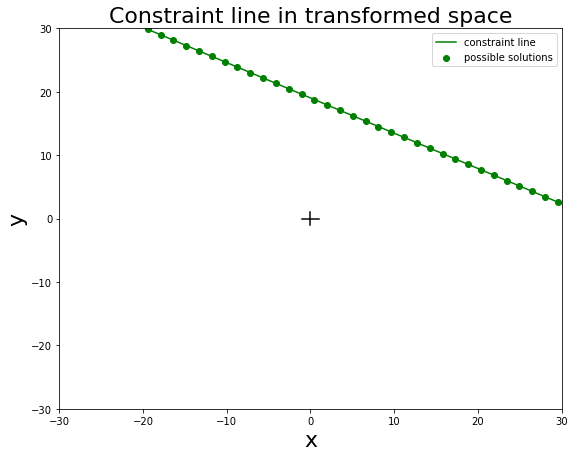

In [260]:
# Now let's plot the possible solution points 
# in their new space and see what it looks like.
# NOTE: the scale of the axes have changed significantly.
plt.figure(figsize=(9, 7))
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.xlim(-30,30)
plt.ylim(-30,30)
# plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# plot the transformed constraint line
plt.scatter(c_tilde[0], c_tilde[1], color='green', label='possible solutions')
plt.plot(c_tilde[0], c_tilde[1], color='green', label='constraint line')
plt.legend()
plt.title('Constraint line in transformed space', fontsize=22)
plt.show()

So we have a new constraint line. The optimal vector v is the vector that lies on this line and is perpendicular to this line. In order to find that, we need to first get the equation for our new line.

In [261]:
# First get the slope
alpha = (c_tilde[1,1] - c_tilde[1,0])/(c_tilde[0,1] - c_tilde[0,0])
print('slope: %0.3f' % alpha)
# Now, observing a point that the line passes through (first point in c_tilde), 
# we can use our y-intercept function to compute the y-intercept
print('y-intercept: %.03f' % compute_yintercept(alpha, c_tilde[:2,0].reshape(-1,)))

slope: -0.556
y-intercept: 19.024


So we have a line $y = -0.556x + 19.024$. Now, let's get the equation for the line perpendicular to this line, that passes through the origin.

In [263]:
# The slope of our perpendicular line is -1/alpha
alpha_p = -1/alpha
print('slope: %0.3f' % alpha_p)

slope: 1.798


So since we have the slope of our line and we know that it passes through the origin, we get the line equation $y = 1.798x$. We want to find the point of intersection between these two lines, so we need to solve for the point that satisfies both line equations. Let's do that:

1. $y = 1.798x$

2. $y = -0.556x + 19.024$

$1.798x = -0.556x + 19.024$

$2.354x = 19.024$

$x = 8.082$

-> $y = 1.798*8.082 = 14.531$

so the solution vector is 

$\tilde{v} = [8.082, 14.531]^T$

In [267]:
v_tilde = np.asarray([[8.082],
                      [14.531]])

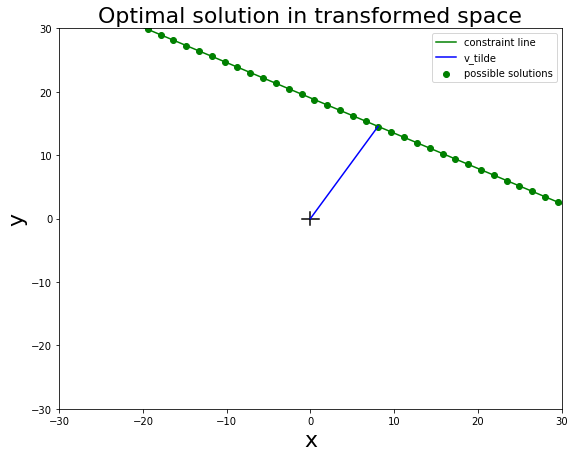

In [268]:
# Let's plot it and see what our solution vector looks like
plt.figure(figsize=(9, 7))
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.xlim(-30,30)
plt.ylim(-30,30)
# plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# plot the possible points c_tilde
plt.scatter(c_tilde[0], c_tilde[1], color='g', label='possible solutions')
plt.plot(c_tilde[0], c_tilde[1], color='g', label='constraint line')
# plot the solution v_tilde
plt.plot([0, v_tilde[0]], [0, v_tilde[1]], color='b', label='v_tilde')
plt.legend()
plt.title('Optimal solution in transformed space', fontsize=22)
plt.show()

## (c)

Since we have $\tilde{v} = SV^T\vec{v}$, then we can get our original $\vec{v}$ back by the following transformation:

$\vec{v} = VS^\#\tilde{v}$

where $S^\#$ is our pseudoinverse of $S$ (function for computing this was written in problem 2).

In [269]:
v = np.matmul(Vh.T, np.matmul(sharp(S)[:2,:2], v_tilde))
print v

[[ 0.74045038]
 [ 2.5012221 ]]


So our solution vector in the original space is

$\vec{v} = [0.740, 2.501]^T$

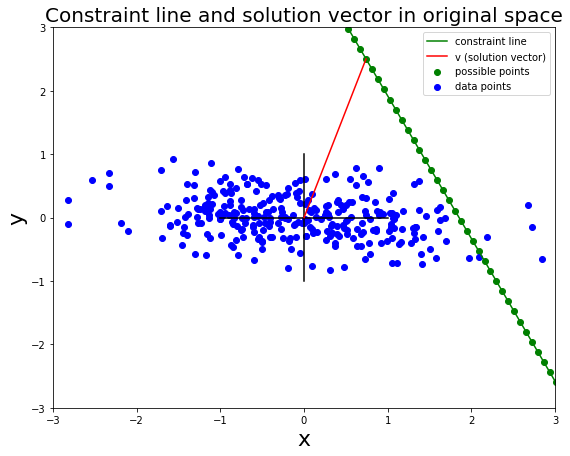

In [270]:
# Let's plot the solution vector with the constraint line
# back in the original space
plt.figure(figsize=(9, 7))
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.xlim(-3,3)
plt.ylim(-3,3)
# plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# plot the constraint line
plt.scatter(x_grid, y_grid, color='green', label='possible points')
plt.plot(x_grid, y_grid, color='green', label='constraint line')
# plot the solution vector
plt.plot([0, v[0]], [0, v[1]], color='r', label='v (solution vector)')
# plot the data points in D
plt.scatter(D[:,0], D[:,1], color='blue', label='data points')
plt.legend()
plt.title('Constraint line and solution vector in original space', fontsize=20)
plt.show()

The optimal vector is not perpendicular to the constraint line.

### The total least squares solution:

Our objective for TLS is to find the unit vector $\hat{u}$ that minimizes our error:

$\min_{\hat{u}} ||D\hat{u}||^2$.

Rewriting this (using algebra from earlier in problem 4):

$\min_{\hat{u}^*} ||S\hat{u}^*||^2$, where $\hat{u}^* = V^T\hat{u}$.

We know here that $\hat{u}^*$ has the same length as $\hat{u}$ because the transformation by orthogonal matrix $V^T$ is just a rotation. From the lecture notes (leastSquares.pdf), we know that the optimal $\hat{u}^*$ is found when 

$\hat{u}^* = \hat{e}_2 = [0, 1]^T$

since we have two singular values (it is always $\hat{e}_N$, where $N$ is the index of the last singular value). We can obtain $\hat{u}$ with the following transformation:

$\hat{u} = V\hat{u}^*$

In [272]:
# let's transform back into original feature space
u_hat_star = np.asarray([[0],
                         [1]])
u_hat = np.matmul(Vh.T, u_hat_star)
print u_hat

[[ 0.10925385]
 [ 0.99401388]]


So the total least squares solution is 

$\hat{u} = [-0.109, 0.994]^T$

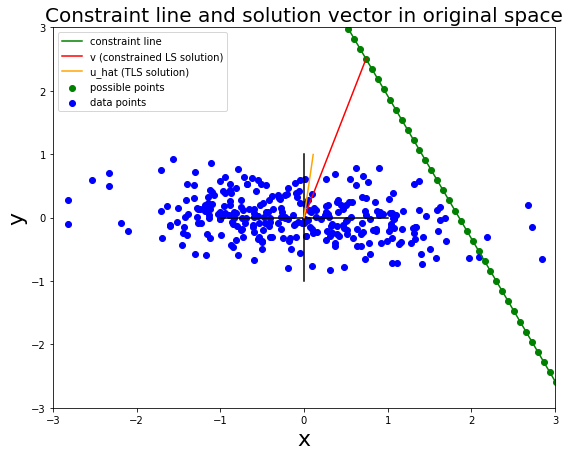

In [273]:
# Let's now add TLS solution to our plot
plt.figure(figsize=(9, 7))
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.xlim(-3,3)
plt.ylim(-3,3)
# plot the axes
plt.plot([-1, 1], [0, 0], c='black')
plt.plot([0, 0], [-1, 1], c='black')
# plot the constraint line
plt.scatter(x_grid, y_grid, color='green', label='possible points')
plt.plot(x_grid, y_grid, color='green', label='constraint line')
# plot the constrained LS solution vector
plt.plot([0, v[0]], [0, v[1]], color='r', label='v (constrained LS solution)')
# plot the TLS solution vector
plt.plot([0, u_hat[0]], [0, u_hat[1]], color='orange', label='u_hat (TLS solution)')
# plot the data points in D
plt.scatter(D[:,0], D[:,1], color='blue', label='data points')
plt.legend()
plt.title('Constraint line and solution vector in original space', fontsize=20)
plt.show()

No, these two solutions are not the same: we can see clearly that they are different vectors.